In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
import math
from pylab import rcParams

from sklearn.model_selection import KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
# Dọc dữ liệu
data = pd.read_csv('/content/META.csv')

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2017,116.029999,117.839996,115.510002,116.860001,116.860001,20663900
1,1/4/2017,117.550003,119.660004,117.290001,118.690002,118.690002,19630900
2,1/5/2017,118.860001,120.949997,118.320000,120.669998,120.669998,19492200
3,1/6/2017,120.980003,123.879997,120.029999,123.410004,123.410004,28545300
4,1/9/2017,123.550003,125.430000,123.040001,124.900002,124.900002,22880400
...,...,...,...,...,...,...,...
1610,5/26/2023,252.929993,262.309998,252.710007,262.040009,262.040009,25727200
1611,5/30/2023,265.250000,268.649994,261.290009,262.519989,262.519989,23816500
1612,5/31/2023,260.000000,265.000000,258.450012,264.720001,264.720001,25473700
1613,6/1/2023,265.899994,274.000000,265.890015,272.609985,272.609985,25609500


<Axes: >

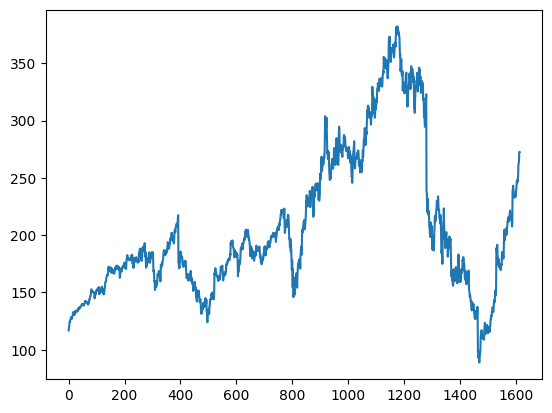

In [ ]:
# Biểu đồ giá đóng cửa của dữ liệu
data['Close'].plot()

In [ ]:
close_data = data[['Date','Close']]
print("Shape of close dataframe:", close_data.shape)

Shape of close dataframe: (1615, 2)


In [ ]:
close_data

,Date,Close
0,1/3/2017,116.860001
1,1/4/2017,118.690002
2,1/5/2017,120.669998
3,1/6/2017,123.410004
4,1/9/2017,124.900002
...,...,...
1610,5/26/2023,262.040009
1611,5/30/2023,262.519989
1612,5/31/2023,264.720001
1613,6/1/2023,272.609985


In [ ]:
close_stock = close_data.Close.values.copy
print(close_stock)

<built-in method copy of numpy.ndarray object at 0x7ff0f0580cf0>


In [ ]:
del close_data['Date']
scaler=MinMaxScaler(feature_range=(0,1))
close_data=scaler.fit_transform(np.array(close_data).reshape(-1,1))
print(close_data.shape)

(1615, 1)


In [ ]:
# chia data: Train 70%, Test 20%, Val 10%

train_size = int(0.7 * len(close_data))
test_size = int(0.2 * len(close_data))
val_size = len(close_data) - train_size - test_size

train_data = close_data[0:train_size,:]
test_data = close_data[train_size:train_size+test_size]
val_data = close_data[train_size+test_size:]

print("Data length :", len(close_data))
print("Train data length :", train_size)
print("Test data length: ",test_size)
print("Validation data lenth :", val_size)

Data length : 1615
Train data length : 1130
Test data length:  323
Validation data lenth : 162


In [ ]:
# Tạo hàm Chuyển mảng thành ma trận
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Chuyển mảng trên từng tập dữ liệu
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val =create_dataset(val_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)
print("X_val: ", X_val.shape)
print("y_val", y_val.shape)

X_train:  (1079, 50)
y_train:  (1079,)
X_test:  (272, 50)
y_test (272,)
X_val:  (111, 50)
y_val (111,)


In [ ]:
# Tạo model XGBregessor

from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train,eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(y_test, predictions)))



Mean Absolute Error - MAE : 0.033821388626876656
Root Mean squared Error - RMSE : 0.047640125956734475
Mean Absolute Percentage Error - MAPE : 0.07031111287847645


In [ ]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)
val_predict=my_model.predict(X_val)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
val_predict = val_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)
print("Val data prediction:", val_predict.shape)

Train data prediction: (1079, 1)
Test data prediction: (272, 1)
Val data prediction: (111, 1)


In [ ]:

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
val_predict = scaler.inverse_transform(val_predict)

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 
original_yval = scaler.inverse_transform(y_val.reshape(-1,1)) 


In [ ]:
test_predict.shape

(272, 1)

In [ ]:
train_predict.shape

(1079, 1)

In [ ]:
time_step

50

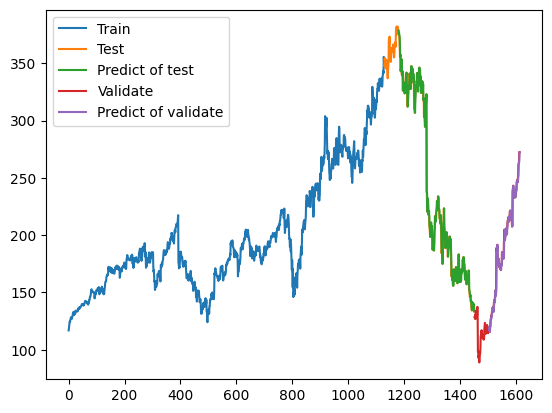

In [ ]:

# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+51, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(original_ytest))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+51, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,original_yval)


plt.legend(['Train','Test','Predict of test','Validate','Predict of validate'])
plt.show()

In [ ]:
#Dung 50 ngay du doan 1 ngay tiep theo
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
# print("Output of predicted next days: ", len(lst_output))

In [ ]:
# Giá trị dự đoán 10 ngày tiếp theo
lst_output = np.array(lst_output)
ot = scaler.inverse_transform(lst_output.reshape(-1,1)) 
ot
for i in range(ot_len):
  print("Dự đoán ngày ", i+1, ":", ot[i])

Dự đoán ngày  1 : [134.55664887]
Dự đoán ngày  2 : [133.5649766]
Dự đoán ngày  3 : [136.13878224]
Dự đoán ngày  4 : [135.43095871]
Dự đoán ngày  5 : [133.66668983]
Dự đoán ngày  6 : [135.63530724]
Dự đoán ngày  7 : [133.72600907]
Dự đoán ngày  8 : [137.67090898]
Dự đoán ngày  9 : [137.58141446]
Dự đoán ngày  10 : [138.04816782]


In [ ]:
# Giá đóng cửa 10 ngày dự đoán
my_model=close_data.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()